# Final Project

    Name: Trisha Mandal         Github username: trish11953         USC ID: 1449602587

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import os
import glob
import re
import math
import numpy as np
import pandas as pd
from statistics import mean, stdev
import matplotlib.pyplot as plt
import statsmodels.api as sm
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import LSTM
from keras.layers import MaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords

In [3]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


# 1. Text Classification
It is highly recommended that you complete this project using Keras1 and Python.

(a) In this problem, we are trying to build a classifier to analyze the sentiment of reviews. You are provided with text data in two folders: one folder involves positive reviews, and one folder involves negative reviews.


In [5]:
# reference: https://docs.python.org/3/library/glob.html

# path1 = "~/Desktop/pastpapers/DSCI\ ML/PDF\ New\ Homework-8/FinalProject/data/neg"
# path1 = r"/Users/USERNAME/Desktop/somedir/somefile.txt"
path1 = "../data/neg"
path2 = "../data/pos"
neg = glob.glob(path1 + '/*')
pos = glob.glob(path2 + '/*')
reviewneg, reviewpos, sentimentneg, sentimentpos = [], [], [], []
for f in neg:
    with open(f, 'r') as f:
        reviewneg.append(f.read())
        sentimentneg.append(0)
for f in pos:
    with open(f, 'r') as f:
        reviewpos.append(f.read())
        sentimentpos.append(1)

(b) Data Exploration and Pre-processing

i. You can use binary encoding for the sentiments , i.e y = 1 for positive senti-
ments and y = −1 for negative sentiments.

In [6]:
rneg = pd.DataFrame (reviewneg, columns = ['Review'])
rpos = pd.DataFrame (reviewpos, columns = ['Review'])
sneg = pd.DataFrame (sentimentneg, columns = ['Sentiment'])
spos = pd.DataFrame (sentimentpos, columns = ['Sentiment'])
hneg = pd.concat([rneg, sneg], axis=1)
hpos = pd.concat([rpos, spos], axis=1)
data = pd.concat([hneg, hpos], axis=0)
data

Review  Sentiment
0    bad . bad . \nbad . \nthat one word seems to p...          0
1    isn't it the ultimate sign of a movie's cinema...          0
2     " gordy " is not a movie , it is a 90-minute-...          0
3    disconnect the phone line . \ndon't accept the...          0
4    when robert forster found himself famous again...          0
..                                                 ...        ...
995  one of the funniest carry on movies and the th...          1
996  i remember making a pact , right after `patch ...          1
997  barely scrapping by playing at a nyc piano bar...          1
998  if the current trends of hollywood filmmaking ...          1
999  capsule : the director of cure brings a weird ...          1

[2000 rows x 2 columns]

ii. The data are pretty clean. Remove the punctuation and numbers from the
data.

In [7]:
# reference: https://stackoverflow.com/questions/12851791/removing-numbers-from-string

data["Review"] = data["Review"].apply(lambda x: re.sub('\W+', ' ', x))
data["Review"] = data["Review"].apply(lambda x: x.strip()) 
data["Review"] = data["Review"].apply(lambda x: re.sub(r"\d+", ' ', x))
data["Review"] = data["Review"].apply(lambda x: x.replace("  ", " "))


In [8]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [9]:
#reference: https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe
stop = stopwords.words('english')
data["Review"] = data["Review"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

data

Review  Sentiment
0    bad bad bad one word seems pretty much sums be...          0
1    ultimate sign movie cinematic ineptitude think...          0
2    gordy movie minute long sesame street skit bad...          0
3    disconnect phone line accept charges anything ...          0
4    robert forster found famous appearing jackie b...          0
..                                                 ...        ...
995  one funniest carry movies third medical settin...          1
996  remember making pact right patch adams easily ...          1
997  barely scrapping playing nyc piano bar timothy...          1
998  current trends hollywood filmmaking continue p...          1
999  capsule director cure brings weird complex con...          1

[2000 rows x 2 columns]

iii. The name of each text file starts with cv number. Use text files 0-699 in each class for training and 700-999 for testing.

In [10]:
negative = data.iloc[0:1000, 0:2]
positive = data.iloc[1000:2000, 0:2]
n1 = negative.iloc[0:700, 0:2]
n2 = negative.iloc[700:1000, 0:2]
p1 = positive.iloc[0:700, 0:2]
p2 = positive.iloc[700:1000, 0:2]
trainingset = pd.concat([n1, p1], axis=0)
testingset = pd.concat([n2, p2], axis=0)
trainingset

Review  Sentiment
0    bad bad bad one word seems pretty much sums be...          0
1    ultimate sign movie cinematic ineptitude think...          0
2    gordy movie minute long sesame street skit bad...          0
3    disconnect phone line accept charges anything ...          0
4    robert forster found famous appearing jackie b...          0
..                                                 ...        ...
695  opening crawl tells us galaxy turmoil taxation...          1
696  surprises long awaited batman movie centers ca...          1
697  like movies albert brooks really like movies d...          1
698  must say outset never much kurt russell fan se...          1
699  left theater seeing david lynch lost highway r...          1

[1400 rows x 2 columns]

In [11]:
data.reset_index(drop=True)
trainingset.reset_index(drop=True)
testingset.reset_index(drop=True)
data["Sentiment"][0]

Review  Sentiment
0     bad bad bad one word seems pretty much sums be...          0
1     ultimate sign movie cinematic ineptitude think...          0
2     gordy movie minute long sesame street skit bad...          0
3     disconnect phone line accept charges anything ...          0
4     robert forster found famous appearing jackie b...          0
...                                                 ...        ...
1995  one funniest carry movies third medical settin...          1
1996  remember making pact right patch adams easily ...          1
1997  barely scrapping playing nyc piano bar timothy...          1
1998  current trends hollywood filmmaking continue p...          1
1999  capsule director cure brings weird complex con...          1

[2000 rows x 2 columns]

Review  Sentiment
0     bad bad bad one word seems pretty much sums be...          0
1     ultimate sign movie cinematic ineptitude think...          0
2     gordy movie minute long sesame street skit bad...          0
3     disconnect phone line accept charges anything ...          0
4     robert forster found famous appearing jackie b...          0
...                                                 ...        ...
1395  opening crawl tells us galaxy turmoil taxation...          1
1396  surprises long awaited batman movie centers ca...          1
1397  like movies albert brooks really like movies d...          1
1398  must say outset never much kurt russell fan se...          1
1399  left theater seeing david lynch lost highway r...          1

[1400 rows x 2 columns]

Review  Sentiment
0    synopsis cro magnon ayla loses mother earthqua...          0
1    contrary popular belief every single foregin f...          0
2    thought stigmata would worst religiously orien...          0
3    years ago national lampoon introduced us new f...          0
4    roger ebert asks review sexy beast would guess...          0
..                                                 ...        ...
595  one funniest carry movies third medical settin...          1
596  remember making pact right patch adams easily ...          1
597  barely scrapping playing nyc piano bar timothy...          1
598  current trends hollywood filmmaking continue p...          1
599  capsule director cure brings weird complex con...          1

[600 rows x 2 columns]

0    0
0    1
Name: Sentiment, dtype: int64

iv. Count the number of unique words in the whole dataset (train + test) and print it out.

In [12]:
#reference: https://www.geeksforgeeks.org/print-unique-words-string/
s = set()
data['Review'].str.lower().str.split().apply(s.update)
print("Number of unique words: ", len(s))

0      None
1      None
2      None
3      None
4      None
       ... 
995    None
996    None
997    None
998    None
999    None
Name: Review, Length: 2000, dtype: object

Number of unique words:  39053


v. Calculate the average review length and the standard deviation of review lengths. Report the results.

In [13]:
numofwords = data["Review"].apply(lambda x: len(str(x).split(' ')))
print("Average of Review Length: ", mean(numofwords))
print("Standard Deviation of Review Length: ", stdev(numofwords))
numofwords

Average of Review Length:  351.276
Standard Deviation of Review Length:  151.8178486001458


0      520
1      302
2      242
3      336
4      193
      ... 
995    247
996    376
997    190
998    431
999    348
Name: Review, Length: 2000, dtype: int64

vi. Plot the histogram of review lengths.

(array([ 93., 600., 792., 338., 110.,  48.,  13.,   3.,   2.,   1.]),
 array([   6. ,  144.1,  282.2,  420.3,  558.4,  696.5,  834.6,  972.7,
        1110.8, 1248.9, 1387. ]),
 <BarContainer object of 10 artists>)

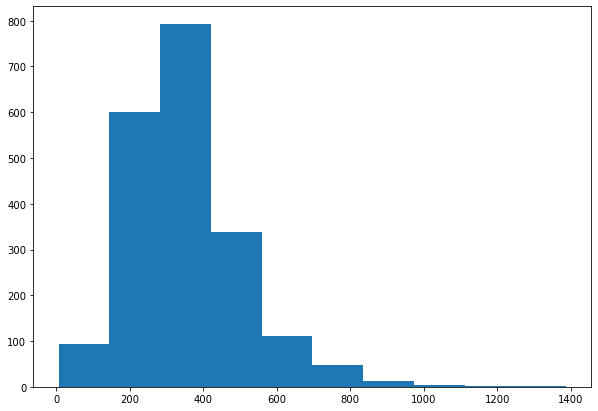

In [14]:
#reference: https://www.geeksforgeeks.org/plotting-histogram-in-python-using-matplotlib/#:~:text=To%20create%20a%20histogram%20the,The%20matplotlib.
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(numofwords)
plt.show()

vii. To represent each text (= data point), there are many ways. In NLP/Deep Learning terminology, this task is called tokenization. It is common to rep- resent text using popularity/ rank of words in text. The most common word in the text will be represented as 1, the second most common word will be represented as 2, etc. Tokenize each text document using this method.

In [15]:
# Taken from code snippets given to us
docs = data["Review"]
t = Tokenizer()
t.fit_on_texts(docs)
print(t.word_counts)
print(t.document_count)
print(t.word_index)
print(t.word_docs)
tokens = t.texts_to_matrix(docs, mode='count')
print(tokens)

OrderedDict([('bad', 1396), ('one', 5854), ('word', 231), ('seems', 1033), ('pretty', 528), ('much', 2050), ('sums', 20), ('beyond', 181), ('valley', 19), ('dolls', 16), ('summary', 12), ('enough', 910), ('still', 1048), ('got', 470), ('point', 685), ('director', 1237), ('russ', 10), ('meyer', 38), ('predilection', 5), ('casting', 129), ('attractive', 83), ('large', 177), ('breasted', 7), ('women', 276), ('ultimately', 158), ('expose', 18), ('afore', 5), ('mentioned', 94), ('anatomical', 1), ('areas', 25), ('really', 1565), ('reason', 437), ('recommend', 106), ('even', 2565), ('taking', 242), ('look', 835), ('movie', 5775), ('fact', 805), ('co', 241), ('written', 409), ('famed', 20), ('film', 9519), ('critic', 70), ('roger', 103), ('ebert', 36), ('also', 1967), ('responsible', 72), ('screenplay', 292), ('watching', 493), ('never', 1375), ('able', 339), ('sit', 144), ('another', 1121), ('reviews', 91), ('gives', 507), ('thumbs', 15), ('writing', 200), ('straight', 200), ('face', 357), (

[[0. 4. 7. ... 0. 0. 0.]
 [0. 1. 7. ... 0. 0. 0.]
 [0. 2. 4. ... 0. 0. 0.]
 ...
 [0. 2. 2. ... 0. 0. 0.]
 [0. 2. 7. ... 0. 0. 0.]
 [0. 4. 5. ... 1. 1. 1.]]


viii. Select a review length L that 70% of the reviews have a length below it. If you feel more adventurous, set the threshold to 90%.

In [16]:
# reference: https://numpy.org/doc/stable/reference/generated/numpy.percentile.html
l = np.percentile(numofwords,90)
print("Review Length for threshold 70%: ", l)

Review Length for threshold 70%:  535.0


ix. Truncate reviews longer than L words and zero-pad reviews shorter than L so that all texts (= data points) are of length L.

In [17]:
# reference: https://medium.com/@canerkilinc/padding-for-nlp-7dd8598c916a
padded = pad_sequences(tokens,padding="post",truncating= "post",maxlen=round(l))
padded.shape

(2000, 535)

(c) Word Embeddings

i. One can use tokenized text as inputs to a deep neural network. However, a recent breakthrough in NLP suggests that more sophisticated representations of text yield better results. These sophisticated representations are called word embeddings. “Word embedding is a term used for representation of words for text analysis, typically in the form of a real-valued vector that encodes the meaning of the word such that the words that are closer in the vector space are expected to be similar in meaning.”4. Most deep learning modules (including Keras) provide a convenient way to convert positive integer rep- resentations of words into a word embedding by an “Embedding layer.” The layer accepts arguments that define the mapping of words into embeddings,including the maximum number of expected words also called the vocabulary size (e.g. the largest integer value). The layer also allows you to specify the dimension for each word vector, called the “output dimension.” We would like to use a word embedding layer for this project. Assume that we are inter- ested in the top 5,000 words. This means that in each integer sequence that represents each document, we set to zero those integers that represent words that are not among the top 5,000 words in the document. If you feel more adventurous, use all the words that appear in this corpus. Choose the length of the embedding vector for each word to be 32. Hence, each document is represented as a 32 × L matrix.

In [18]:
#reference: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
model = Sequential()
model.add(Embedding(5000, 32, input_length = round(l)))


2022-07-25 21:39:52.027368: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


ii. Flatten the matrix of each document to a vector

In [19]:
model.add(Flatten())

In [20]:
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 535, 32)           160000    
                                                                 
 flatten (Flatten)           (None, 17120)             0         
                                                                 
 dense (Dense)               (None, 1)                 17121     
                                                                 
Total params: 177,121
Trainable params: 177,121
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
model.fit(padded, np.array(data["Sentiment"]), epochs=2, verbose=0)
loss, accuracy = model.evaluate(padded, np.array(data["Sentiment"]), verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 84.850001


(d) Multi-Layer Perceptron

i. Train a MLP with three (dense) hidden layers each of which has 50 ReLUs and one output layer with a single sigmoid neuron. Use a dropout rate of 20% for the first layer and 50% for the other layers. Use ADAM optimizer and binary cross entropy loss (which is equivalent to having a softmax in the output). To avoid overfitting, just set the number of epochs as 2. Use a batch size of 10.

In [22]:
docs2 = trainingset["Review"]
t2 = Tokenizer()
t2.fit_on_texts(docs2)
print(t2.word_counts)
print(t2.document_count)
print(t2.word_index)
print(t2.word_docs)
tokens2 = t2.texts_to_matrix(docs2, mode='count')
print(tokens2)

OrderedDict([('bad', 948), ('one', 4122), ('word', 157), ('seems', 723), ('pretty', 351), ('much', 1443), ('sums', 15), ('beyond', 116), ('valley', 9), ('dolls', 11), ('summary', 9), ('enough', 641), ('still', 732), ('got', 310), ('point', 483), ('director', 868), ('russ', 9), ('meyer', 30), ('predilection', 3), ('casting', 98), ('attractive', 50), ('large', 122), ('breasted', 6), ('women', 200), ('ultimately', 117), ('expose', 13), ('afore', 4), ('mentioned', 65), ('anatomical', 1), ('areas', 16), ('really', 1087), ('reason', 322), ('recommend', 73), ('even', 1835), ('taking', 173), ('look', 607), ('movie', 4040), ('fact', 565), ('co', 183), ('written', 279), ('famed', 15), ('film', 6700), ('critic', 57), ('roger', 66), ('ebert', 30), ('also', 1355), ('responsible', 50), ('screenplay', 202), ('watching', 334), ('never', 975), ('able', 244), ('sit', 98), ('another', 813), ('reviews', 56), ('gives', 367), ('thumbs', 12), ('writing', 138), ('straight', 143), ('face', 263), ('stinks', 11)

[[0. 4. 7. ... 0. 0. 0.]
 [0. 1. 7. ... 0. 0. 0.]
 [0. 2. 4. ... 0. 0. 0.]
 ...
 [0. 4. 3. ... 0. 0. 0.]
 [0. 4. 6. ... 0. 0. 0.]
 [0. 9. 4. ... 1. 1. 1.]]


In [23]:
padded2 = pad_sequences(tokens2,padding="post",truncating= "post",maxlen=round(l))
padded2.shape

(1400, 535)

In [24]:
len(tokens2)

1400

In [25]:
model2 = Sequential()
model2.add(Embedding(5000, 32, input_length = round(l)))

In [26]:
model2.add(Flatten())
model2.add(Dense(50,activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(50,activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(50,activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1,activation='sigmoid'))
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 535, 32)           160000    
                                                                 
 flatten_1 (Flatten)         (None, 17120)             0         
                                                                 
 dense_1 (Dense)             (None, 50)                856050    
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 50)               

In [27]:
docs3 = testingset["Review"]
t3 = Tokenizer()
t3.fit_on_texts(docs3)
print(t3.word_counts)
print(t3.document_count)
print(t3.word_index)
print(t3.word_docs)
tokens3 = t3.texts_to_matrix(docs3, mode='count')
print(tokens3)

OrderedDict([('synopsis', 21), ('cro', 2), ('magnon', 2), ('ayla', 6), ('loses', 28), ('mother', 117), ('earthquake', 7), ('escapes', 12), ('certain', 61), ('death', 160), ('lion', 7), ('reluctantly', 13), ('rescued', 7), ('neanderthal', 4), ('clan', 15), ('likes', 29), ('sex', 148), ('doggy', 2), ('style', 98), ('grows', 24), ('become', 154), ('blond', 8), ('feminist', 6), ('supermodel', 5), ('challenges', 4), ('patriarchy', 1), ('throwing', 15), ('rocks', 8), ('giving', 73), ('birth', 16), ('without', 199), ('mate', 10), ('comments', 20), ('allow', 22), ('state', 43), ('record', 21), ('find', 260), ('daryl', 10), ('hannah', 8), ('appealing', 31), ('presence', 52), ('movies', 400), ('proved', 10), ('quite', 194), ('charming', 25), ('intelligent', 48), ('astronomer', 6), ('romantic', 83), ('comedy', 247), ('roxanne', 1), ('equally', 40), ('creepy', 29), ('pris', 1), ('sci', 41), ('fi', 42), ('classic', 95), ('blade', 16), ('runner', 11), ('cave', 8), ('bear', 18), ('clearly', 46), ('tr

[[0. 4. 9. ... 0. 0. 0.]
 [0. 5. 1. ... 0. 0. 0.]
 [0. 5. 6. ... 0. 0. 0.]
 ...
 [0. 2. 2. ... 0. 0. 0.]
 [0. 2. 4. ... 0. 0. 0.]
 [0. 4. 0. ... 1. 1. 1.]]


In [28]:
padded3 = pad_sequences(tokens3,padding="post",truncating= "post",maxlen=round(l))
padded3.shape

(600, 535)

In [29]:
model3 = Sequential()
model3.add(Embedding(5000, 32, input_length = round(l)))

In [30]:
model3.add(Flatten())
model3.add(Dense(50,activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(50,activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(50,activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(1,activation='sigmoid'))
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 535, 32)           160000    
                                                                 
 flatten_2 (Flatten)         (None, 17120)             0         
                                                                 
 dense_5 (Dense)             (None, 50)                856050    
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 50)                2550      
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 50)               

ii. Report the train and test accuracies of this model.

In [31]:
testingset['Sentiment'].value_counts()

0    300
1    300
Name: Sentiment, dtype: int64

In [32]:
model2.fit(padded2, np.array(trainingset["Sentiment"]), epochs=2, verbose=0, batch_size = 10)
loss, accuracy = model2.evaluate(padded2, np.array(trainingset["Sentiment"]), verbose=0)
print('Training set Accuracy: %f' % (accuracy*100))

Training set Accuracy: 79.142857


In [33]:
loss, accuracy = model3.evaluate(padded3, np.array(testingset["Sentiment"]), verbose=0)
print('Testing set Accuracy: %f' % (accuracy*100))

Testing set Accuracy: 48.500001


(e) One-Dimensional Convolutional Neural Network:
Although CNNs are mainly used for image data, they can also be applied to text data, as text also has adjacency information. Keras supports one-dimensional convolutions and pooling by the Conv1D and MaxPooling1D classes respectively.

i. After the embedding layer, insert a Conv1D layer. This convolutional layer has 32 feature maps , and each of the 32 kernels has size 3, i.e. reads embedded word representations 3 vector elements of the word embedding at a time. The convolutional layer is followed by a 1D max pooling layer with a length and stride of 2 that halves the size of the feature maps from the convolutional layer. The rest of the network is the same as the neural network above.

In [34]:
#reference: https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/
model4 = Sequential()
model4.add(Embedding(5000, 32, input_length = round(l)))
model4.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(round(l),32)))
model4.add(MaxPooling1D(pool_size=2))
model4.add(Flatten())
model4.add(Dense(50,activation='relu'))
model4.add(Dropout(0.2))
model4.add(Dense(50,activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(50,activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(1,activation='sigmoid'))
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model4.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 535, 32)           160000    
                                                                 
 conv1d (Conv1D)             (None, 533, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 266, 32)          0         
 )                                                               
                                                                 
 flatten_3 (Flatten)         (None, 8512)              0         
                                                                 
 dense_9 (Dense)             (None, 50)                425650    
                                                                 
 dropout_6 (Dropout)         (None, 50)                0         
                                                      

ii. Report the train and test accuracies of this model.

In [35]:
model4.fit(padded2, np.array(trainingset["Sentiment"]), epochs=2, verbose=0, batch_size = 10)
loss, accuracy = model4.evaluate(padded2, np.array(trainingset["Sentiment"]), verbose=0)
print('Training set Accuracy: %f' % (accuracy*100))

Training set Accuracy: 66.428572


In [36]:
loss, accuracy = model4.evaluate(padded3, np.array(testingset["Sentiment"]), verbose=0)
print('Testing set Accuracy: %f' % (accuracy*100))

Testing set Accuracy: 53.333336


(f) Long Short-Term Memory Recurrent Neural Network:
The structure of the LSTM we are going to use is shown in the following figure.

i. Each word is represented to LSTM as a vector of 32 elements and the LSTM is followed by a dense layer of 256 ReLUs. Use a dropout rate of 0.2 for both LSTM and the dense layer. Train the model using 10-50 epochs and batch size of 10.

In [37]:
model5= Sequential()
model5.add(Embedding(5000,32,input_length=round(l)))
model5.add(LSTM(units=32,dropout=0.2))
model5.add(Flatten())
model5.add(Dense(256,activation='relu'))
model5.add(Dropout(0.2))
model5.add(Dense(1,activation='sigmoid'))
model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model5.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 535, 32)           160000    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 flatten_4 (Flatten)         (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 256)               8448      
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 1)                 257       
                                                                 
Total params: 177,025
Trainable params: 177,025
Non-tr

ii. Report the train and test accuracies of this model.

In [38]:
model5.fit(padded2, np.array(trainingset["Sentiment"]), epochs=50, verbose=0, batch_size = 10)
loss, accuracy = model5.evaluate(padded2, np.array(trainingset["Sentiment"]), verbose=0)
print('Training set Accuracy: %f' % (accuracy*100))

Training set Accuracy: 66.428572


In [39]:
loss, accuracy = model5.evaluate(padded3, np.array(testingset["Sentiment"]), verbose=0)
print('Testing set Accuracy: %f' % (accuracy*100))

Testing set Accuracy: 54.666668


# References

https://docs.python.org/3/library/glob.html

https://stackoverflow.com/questions/12851791/removing-numbers-from-string

https://www.geeksforgeeks.org/print-unique-words-string/

https://www.geeksforgeeks.org/plotting-histogram-in-python-using-matplotlib/#:~:text=To%20create%20a%20histogram%20the,The%20matplotlib.

https://numpy.org/doc/stable/reference/generated/numpy.percentile.html

https://medium.com/@canerkilinc/padding-for-nlp-7dd8598c916a

https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/

https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe

https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe